In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import time
import os
import argparse
import gdreg
import matplotlib.pyplot as plt

# autoreload
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler
%load_ext line_profiler

In [2]:
JOB = "compute_score"
PGEN_FILE = "/n/groups/price/martin/WES_analysis/toy_10K/chr@_v1.SPB.hg19.toy_10K"
LD_FILE = "/n/groups/price/martin/WES_analysis/toy_10K/res_gdreg/toy_10K.c1_s3000_e4232_ld.npz"
ANNOT_FILE = "/n/groups/price/martin/WES_analysis/toy_1K/toy.annot.gz," + \
    "/n/groups/price/martin/WES_analysis/toy_1K/toy.pannot.gz," + \
    "/n/groups/price/martin/WES_analysis/toy_1K/toy.pannot_hr.gz"
PREFIX_OUT = "/n/groups/price/martin/WES_analysis/toy_10K/res_gdreg/toy_10K"

SNP_RANGE = None
SUMSTATS_FILE = None
RANDOM_SEED = 0
MEMORY = 256
FLAG_FULL_LD = False

In [3]:
sys_start_time = time.time()

###########################################################################################
######                                    Parse Options                              ######
###########################################################################################

# JOB = args.job
# PGEN_FILE = args.pgen_file
# LD_FILE = args.ld_file
# SUMSTATS_FILE = args.sumstats_file
# ANNOT_FILE = args.annot_file
# PREFIX_OUT = args.prefix_out
# MEMORY = args.memory
# RANDOM_SEED = args.random_seed
# SNP_RANGE = args.snp_range
# FLAG_FULL_LD = args.flag_full_ld

# Parse and check arguments
LEGAL_JOB_LIST = ["get_snp_block", "compute_ld", "compute_score", "regress"]
err_msg = "# run_gdreg: --job=%s not supported" % JOB
assert JOB in LEGAL_JOB_LIST, err_msg

if JOB in ["compute_score", "regress"]:
    assert LD_FILE is not None, "--ld_file required for --job=%s" % JOB
if JOB in ["regress"]:
    assert SUMSTATS_FILE is not None, "--sumstats_file required for --job=%s" % JOB
if JOB in ["compute_score", "regress"]:
    assert ANNOT_FILE is not None, "--annot_file required for --job=%s" % JOB
if JOB in ["compute_ld"]:
    assert SNP_RANGE is not None, "--snp_range required for --job=%s" % JOB
    DIC_RANGE = gdreg.util.parse_snp_range(SNP_RANGE)    

# Print input options
header = gdreg.util.get_cli_head()
header += "Call: run_gdreg.py \\\n"
header += "--job %s\\\n" % JOB
header += "--pgen_file %s\\\n" % PGEN_FILE
header += "--ld_file %s\\\n" % LD_FILE
header += "--sumstats_file %s\\\n" % SUMSTATS_FILE
header += "--annot_file %s\\\n" % ANNOT_FILE
header += "--prefix_out %s\\\n" % PREFIX_OUT
header += "--snp_range %s\\\n" % SNP_RANGE
header += "--memory %d\\\n" % MEMORY
header += "--random_seed %d\\\n" % RANDOM_SEED
header += "--flag_full_ld %s\n" % FLAG_FULL_LD
print(header)

******************************************************************************
* Gene-level directional effect regression (GDREG)
* Version 0.0.2
* Martin Jinye Zhang
* HSPH / Broad Institute
* MIT License
******************************************************************************
Call: run_gdreg.py \
--job compute_score\
--pgen_file /n/groups/price/martin/WES_analysis/toy_10K/chr@_v1.SPB.hg19.toy_10K\
--ld_file /n/groups/price/martin/WES_analysis/toy_10K/res_gdreg/toy_10K.c1_s3000_e4232_ld.npz\
--sumstats_file None\
--annot_file /n/groups/price/martin/WES_analysis/toy_1K/toy.annot.gz,/n/groups/price/martin/WES_analysis/toy_1K/toy.pannot.gz,/n/groups/price/martin/WES_analysis/toy_1K/toy.pannot_hr.gz\
--prefix_out /n/groups/price/martin/WES_analysis/toy_10K/res_gdreg/toy_10K\
--snp_range None\
--memory 256\
--random_seed 0\
--flag_full_ld False



In [4]:
###########################################################################################
######                                   Data Loading                                ######
###########################################################################################
# Load --pgen_file
if JOB in ["get_snp_block", "compute_ld", "compute_score", "regress"]:
    print("# Loading --pgen_file")
    dic_data = {}
    if "@" not in PGEN_FILE:
        temp_dic = gdreg.util.read_pgen(PGEN_FILE)
        dic_data[temp_dic["pvar"]["CHR"][0]] = temp_dic.copy()
    else:
        for CHR in range(1, 23):
            if os.path.exists(PGEN_FILE.replace("@", "%s" % CHR) + ".pgen"):
                dic_data[CHR] = gdreg.util.read_pgen(
                    PGEN_FILE.replace("@", "%s" % CHR)
                )

    for CHR in dic_data:
        n_sample = dic_data[CHR]["psam"].shape[0]
        n_snp = dic_data[CHR]["pvar"].shape[0]
        mat_X = gdreg.util.read_geno(
            dic_data[CHR]["pgen"], 0, 50, n_sample=None, n_snp=None
        )
        sparsity = (mat_X != 0).mean()
        print(
            "    CHR%2d: %d samples, %d SNPs, %0.1f%% non-zeros for first 50 SNPs"
            % (CHR, n_sample, n_snp, sparsity * 100)
        )
    print("    " + gdreg.util.get_sys_info(sys_start_time))

# Load --ld_file
if JOB in ["compute_score", "regress"]:
    print("# Loading --ld_file")
    assert os.path.exists(LD_FILE), "--ld_file does not exist"
    mat_ld,dic_range = gdreg.util.read_ld(LD_FILE)
    if dic_range['chr_ref'] is None:
        dic_range['chr_ref'] = dic_range['chr']
    err_msg = "n_snp=%d, mismatch with --pgen_file" % mat_ld.shape[0]
    assert mat_ld.shape[0] == dic_data[dic_range['chr']]["pvar"].shape[0], err_msg
    print("    chr=%d, start=%d, end=%d, chr_ref=%d" % (
        dic_range['chr'], dic_range['start'], dic_range['end'], dic_range['chr_ref']
    ))
    print("    n_snp=%d, n_snp_ref=%d" % (mat_ld.shape[1], mat_ld.shape[0]))
    print("    LD info loaded, matching --pgen_file")
    print("    " + gdreg.util.get_sys_info(sys_start_time))

# Load --sumstats_file
if JOB in ["regress"]:
    print("# Loading --sumstats_file")
    df_sumstats = pd.read_csv(SUMSTATS_FILE, sep="\t", index_col=None)
    print("    .sumstats.gz loaded, %d SNPs" % df_sumstats.shape[0])
    print("    " + gdreg.util.get_sys_info(sys_start_time))

# Load --annot_file
if JOB in ["compute_score", "regress"]:
    print("# Loading --annot_file")
    df_annot = None
    pannot_list = []
    pannot_hr_list = []
    for annot_file in ANNOT_FILE.split(","):
        err_msg = "--annot_file missing : '%s'" % annot_file
        assert os.path.exists(annot_file), err_msg
        temp_df = gdreg.util.read_annot(annot_file)

        if annot_file.endswith(".annot.gz"):
            temp_df.index = temp_df["SNP"]
            if df_annot is None:
                df_annot = temp_df.copy()
            else:
                col_list = [x for x in temp_df if x.startswith("AN:")]
                df_annot = df_annot.join(temp_df[col_list])
        if annot_file.endswith(".pannot.gz"):
            pannot_list.append(temp_df.copy())
        if annot_file.endswith(".pannot_hr.gz"):
            pannot_hr_list.append(temp_df.copy())
    AN_list = [x for x in df_annot if x.startswith("AN:")]
    print(
        "    .annot.gz (%d SNPs and %d annots): %s"
        % (df_annot.shape[0], len(AN_list), ",".join(AN_list))
    )
    temp_list = ["%s (%d SNPs)" % (x.columns[-1], x.shape[0]) for x in pannot_list]
    print(
        "    .pannot.gz (%d pannots): %s" % (len(pannot_list), ",".join(temp_list)),
    )
    temp_list = [
        "%s (%d pairs)" % (x.columns[-1], x.shape[0]) for x in pannot_hr_list
    ]
    print(
        "    .pannot_hr.gz (%d pannots): %s"
        % (len(pannot_hr_list), ",".join(temp_list)),
    )
    print("    " + gdreg.util.get_sys_info(sys_start_time))

# Loading --pgen_file
    CHR 1: 10000 samples, 4232 SNPs, 26.7% non-zeros for first 50 SNPs
    CHR 2: 10000 samples, 4056 SNPs, 43.5% non-zeros for first 50 SNPs
    CHR 3: 10000 samples, 4067 SNPs, 33.9% non-zeros for first 50 SNPs
    CHR 4: 10000 samples, 4027 SNPs, 24.2% non-zeros for first 50 SNPs
    CHR 5: 10000 samples, 4106 SNPs, 36.7% non-zeros for first 50 SNPs
    CHR 6: 10000 samples, 4154 SNPs, 39.6% non-zeros for first 50 SNPs
    CHR 7: 10000 samples, 4071 SNPs, 41.8% non-zeros for first 50 SNPs
    CHR 8: 10000 samples, 3891 SNPs, 33.3% non-zeros for first 50 SNPs
    CHR 9: 10000 samples, 4149 SNPs, 40.1% non-zeros for first 50 SNPs
    CHR10: 10000 samples, 4129 SNPs, 40.3% non-zeros for first 50 SNPs
    sys_time=2.9s, sys_mem=0.11GB
# Loading --ld_file
    chr=1, start=3000, end=4232, chr_ref=1
    n_snp=1232, n_snp_ref=4232
    LD info loaded, matching --pgen_file
    sys_time=3.0s, sys_mem=0.12GB
# Loading --annot_file
    .annot.gz (40882 SNPs and 3 annots): A

In [41]:
if JOB == "compute_score":
    # Zero pad for mat_ld
    CHR, START, END = dic_range["chr"], dic_range["start"], dic_range["end"]
    n_sample, n_snp = dic_data[CHR]["pvar"].shape
    
    mat_ld_list = []
    if START>0:
        mat_ld_list.append(sp.sparse.csc_matrix(([0], ([0], [0])), shape=[n_sample, START], dtype=np.float32))
    mat_ld_list.append(mat_ld)
    if END < n_snp:
        mat_ld_list.append(sp.sparse.csc_matrix(([0], ([0], [0])), shape=[n_sample, n_snp-END], dtype=np.float32))
    dic_ld = {CHR : sp.sparse.hstack(mat_ld_list, format="csc")}
    snp_range = (dic_range['chr'], dic_range['start'], dic_range['end'])
    
    df_score = gdreg.score.compute_score(
        dic_data, 
        dic_ld,
        df_annot,
        pannot_list,
        pannot_hr_list,
        verbose = True,
        win_size = 1e7,
        snp_range = snp_range,
    )
    
    df_score.to_csv(
        PREFIX_OUT + ".c%d_s%d_e%d_score.tsv.gz" % (CHR, START, END), sep='\t', index=False, compression='gzip'
    )

# Call: gdreg.score.compute_score
    4232 SNPs from 1 CHRs: CHR1 (4232 SNPs)
    Range: chr=1, start=3000, end=4232 
    Single-SNP annots : AN:ALL, AN:CHR1t5, AN:ODD
    SNP-pair annots : pAN:gene, pAN:proxy (hr)
    win_size=10.0MB, memory=128MB
    Completed, time=0.3s


In [39]:
dic_ld[1].dtype

dtype('float32')

In [24]:
mat_ld

<4232x1232 sparse matrix of type '<class 'numpy.float32'>'
	with 1512310 stored elements in Compressed Sparse Column format>

### Test for correctness

In [19]:
# Read in all LD matrices 
dic_ld_full = {}
temp_path = "/n/groups/price/martin/WES_analysis/toy_1K/results/full_ld"
for CHR in range(1,11):
    for CHR_REF in range(1,11):
        dic_ld_full[(CHR,CHR_REF)] = np.load(
            temp_path + '/top_1K_chr%d_chr%d.ld.npy' % (CHR, CHR_REF)
        )

FileNotFoundError: [Errno 2] No such file or directory: '/n/groups/price/martin/WES_analysis/toy_1K/results/full_ld/top_1K_chr1_chr1.ld.npy'

In [11]:
# E score for CHR
CHR = 6
v_score = np.diag(dic_ld_full[(CHR,CHR)])
print('abs_dif=%0.3g' % np.absolute(v_score - df_score.loc[df_score['CHR']==CHR, 'E'].values).sum())

abs_dif=0


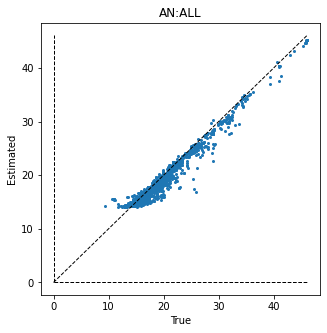

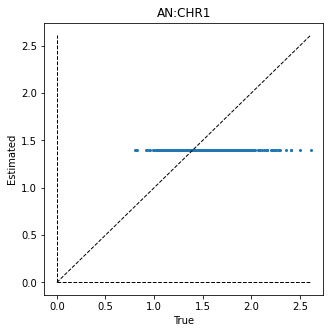

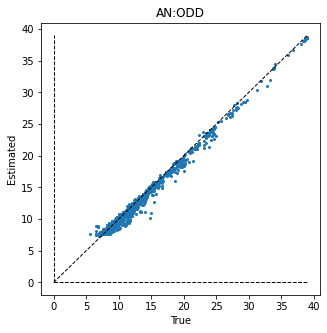

In [15]:
# LD score for CHR1
CHR = 3
mat_ld_chr = np.concatenate([dic_ld_full[(CHR,x)] for x in range(1,11)], axis=0)
for AN in ['AN:ALL', 'AN:CHR1', 'AN:ODD']:
    v_annot = df_annot[AN].values
    v_ld_score = ((mat_ld_chr**2).T*v_annot).sum(axis=1)
    
    plt.figure(figsize=[5,5])
    plt.scatter(v_ld_score, df_score.loc[df_score['CHR']==CHR, 'LD:%s'%AN], s=4)
    x_max = max(v_ld_score.max(), df_score.loc[df_score['CHR']==CHR, 'LD:%s'%AN].max())
    plt.plot([0, x_max], [0, x_max], '--', color='k', linewidth=1)
    plt.plot([0, x_max], [0, 0], '--', color='k', linewidth=1)
    plt.plot([0, 0], [0, x_max], '--', color='k', linewidth=1)
    plt.title(AN)
    plt.xlabel('True')
    plt.ylabel('Estimated')
    plt.show()

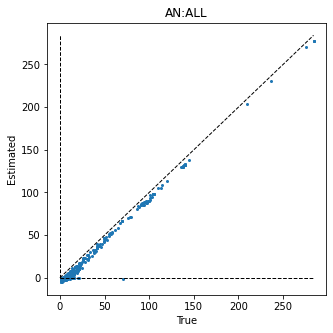

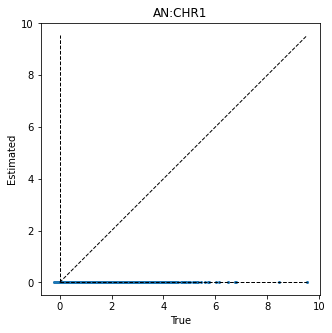

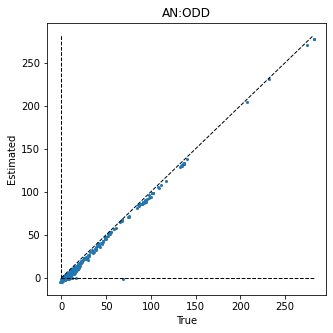

In [27]:
# DLD score using .pannot for CHR1
CHR,pAN = 3,'pAN:gene'
mat_ld_chr = np.concatenate([dic_ld_full[(CHR,x)] for x in range(1,11)], axis=0)
mat_S = gdreg.util.pannot_to_csr(pannot_list[0][pAN])
mat_G = mat_S.dot(mat_S.T).toarray()
np.fill_diagonal(mat_G, 0)
                
for AN in ['AN:ALL', 'AN:CHR1', 'AN:ODD']:
    v_annot = df_annot[AN].values
    v_dld_score = gdreg.score.compute_dld_score(
        mat_ld_chr, mat_G, df_annot[AN].values, np.ones(mat_G.shape[0])
    )
    
    plt.figure(figsize=[5,5])
    plt.scatter(v_dld_score, df_score.loc[df_score['CHR']==CHR, 'DLD:%s|%s'%(pAN,AN)], s=4)
    x_max = max(v_dld_score.max(), df_score.loc[df_score['CHR']==CHR, 'DLD:%s|%s'%(pAN,AN)].max())
    plt.plot([0, x_max], [0, x_max], '--', color='k', linewidth=1)
    plt.plot([0, x_max], [0, 0], '--', color='k', linewidth=1)
    plt.plot([0, 0], [0, x_max], '--', color='k', linewidth=1)
    plt.title(AN)
    plt.xlabel('True')
    plt.ylabel('Estimated')
    plt.show()

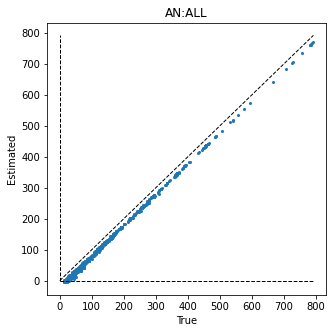

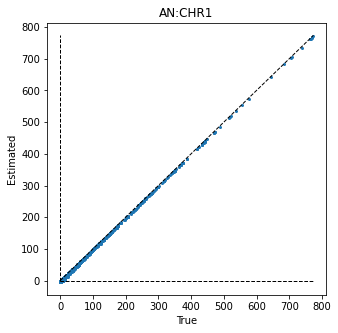

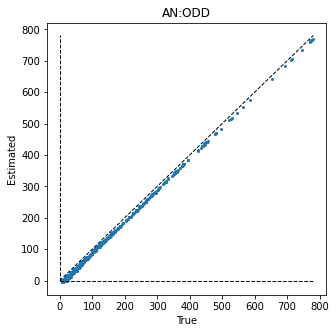

In [28]:
# DLD score using .pannot_hr for CHR1
CHR,pAN = 1,'pAN:proxy'
mat_ld_chr = np.concatenate([dic_ld_full[(CHR,x)] for x in range(1,11)], axis=0)
snp_pair_list  = [(x, y) for x, y in zip(pannot_hr_list[0]["SNP"], pannot_hr_list[0]["pSNP"])]
mat_G = gdreg.util.pannot_hr_to_csr(df_annot["SNP"], snp_pair_list)#.toarray()
                
for AN in ['AN:ALL', 'AN:CHR1', 'AN:ODD']:
    v_annot = df_annot[AN].values
    v_dld_score = gdreg.score.compute_dld_score(
        mat_ld_chr, mat_G, df_annot[AN].values, np.ones(mat_G.shape[0])
    )
    
    plt.figure(figsize=[5,5])
    plt.scatter(v_dld_score, df_score.loc[df_score['CHR']==CHR, 'DLD:%s|%s'%(pAN,AN)], s=4)
    x_max = max(v_dld_score.max(), df_score.loc[df_score['CHR']==CHR, 'DLD:%s|%s'%(pAN,AN)].max())
    plt.plot([0, x_max], [0, x_max], '--', color='k', linewidth=1)
    plt.plot([0, x_max], [0, 0], '--', color='k', linewidth=1)
    plt.plot([0, 0], [0, x_max], '--', color='k', linewidth=1)
    plt.title(AN)
    plt.xlabel('True')
    plt.ylabel('Estimated')
    plt.show()

### Test for gdreg.score.compute_dld_score

In [184]:
n_snp = 10
n_snp_ref = 50
np.random.seed(0)
mat_ld = np.random.randn(n_snp_ref, n_snp)
mat_G = np.random.choice([0,1], size=[n_snp_ref, n_snp_ref])
mat_G = (mat_G + mat_G.T).astype(bool)
# mat_G = sp.sparse.csr_matrix(mat_G)
v_annot = np.random.randn(n_snp_ref)
v_ps_sd = np.random.rand(n_snp_ref) 

v_score_gold = [
    mat_ld[:,x].reshape([-1,1]).T.dot(
        mat_G * 0.5 * (np.outer(v_annot, np.ones(n_snp_ref)) + np.outer(np.ones(n_snp_ref), v_annot))
        * np.outer(v_ps_sd, v_ps_sd)).dot(
        mat_ld[:,x].reshape([-1,1])
    )[0][0] for x in range(n_snp)
]
v_score_gold = np.array(v_score_gold)

v_score = gdreg.score.compute_dld_score(mat_ld, mat_G, v_annot, v_ps_sd)
print('abs_dif=%0.3g'%np.absolute(v_score_gold - v_score).sum())

v_score = gdreg.score.compute_dld_score(mat_ld, sp.sparse.csr_matrix(mat_G), v_annot, v_ps_sd)
print('abs_dif=%0.3g'%np.absolute(v_score_gold - v_score).sum())

abs_dif=1.22e-14
abs_dif=1.22e-14


### Test for gdreg.score.reg_block_jn

In [106]:
n_sample = 1000
v_beta = np.array([1, 2])
n_rep = 1000
mat_X = np.random.multivariate_normal([0, 0], [[1,-0.5], [-0.5,1]], size=n_sample)

dic_block = {
    0 : [0, 50],
    1 : [50, 200],
    2 : [200, 300],
    3 : [300, 350],
    4 : [350, 450],
    5 : [450, 500],
    6 : [500, 600],
    7 : [600, 1000],
}

mat_coef = np.zeros([n_rep, 2])
ten_cov = np.zeros([n_rep, 2, 2])
for i_rep in range(n_rep):
    np.random.seed(i_rep)
    v_y = mat_X.dot(v_beta) + np.random.randn(n_sample) * 5
    coef_full, coef_mean, coef_cov = gdreg.regress.reg_block_jn(v_y, mat_X, dic_block)
    mat_coef[i_rep, :] = coef_mean
    ten_cov[i_rep, :, :] = coef_cov

print('Estimate:')
print(mat_coef.mean(axis=0))
print('Empi cov:')
print(np.cov(mat_coef.T))
print('JN cov:')
print(ten_cov.mean(axis=0))

Estimate:
[1.00502031 1.99207107]
Empi cov:
[[0.03118544 0.01392717]
 [0.01392717 0.02914277]]
JN cov:
[[0.03139338 0.01407368]
 [0.01407368 0.03214365]]


In [93]:
coef_full, coef_mean, coef_cov = gdreg.regress.reg_block_jn(v_y, mat_X, dic_block, verbose=True)

# Call: gdreg.regress.reg_block_jn
    n_sample=1000, n_regressor=2, n_block=8
